# Raman spectra analysis

Importing necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import math
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import argrelmin, argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats import ttest_ind
import seaborn as sns

Your measurements should be copied to the "data" folder.
Output results can be saved in "output" polder.

In [2]:
data_directory = 'data/'
out_directory = 'output/'

Reading and combining all .csv files into one dataframe.

In [3]:
def combine_files(data_directory):
    """ Read in all data files and combine into one combined DataFrame
    """
    all_data = pd.DataFrame()
    nameit =[]
    for f in glob.glob(os.path.join(data_directory, "*.csv")):
        df = pd.read_csv(f,skiprows=(30),sep=";")[:-2] #first 30 and the last two rows with the metadata are removed
        n = f.replace(data_directory," ") #getting the names
        n = n.replace("_", " ")[5:-4] # replace symbols from file names 
        df.rename(columns={ df.columns[0]: n }, inplace = True)
        all_data = pd.concat([all_data, df.T])
        nameit.append(n)
    all_data = all_data.astype(float)
    all_data.columns.values.astype(float)
    return all_data, nameit #nameit

Resulting dataframe contains spectral intensities from each measurement in a row-vise manner. The Raman shifts are stored as the column names.

In [4]:
all_data, nameit = combine_files(data_directory)
all_data.head()

,100.00,102.00,104.00,106.00,108.00,110.00,112.00,114.00,116.00,118.00,...,2282.00,2284.00,2286.00,2288.00,2290.00,2292.00,2294.00,2296.00,2298.00,2300.00
11,1421.51,1417.44,1412.91,1400.29,1387.43,1372.10,1349.46,1315.73,1282.85,1262.37,...,329.34,347.36,348.49,356.23,351.67,338.47,335.63,339.12,340.78,328.02
12,1803.63,1792.70,1778.93,1760.10,1731.35,1709.19,1671.55,1625.07,1586.47,1546.75,...,417.10,386.30,408.12,394.75,410.04,420.53,417.54,401.33,392.13,415.99
4,7690.82,7595.43,7475.08,7329.52,7158.08,6976.34,6790.88,6569.97,6338.88,6097.84,...,1378.46,1399.99,1372.87,1371.18,1360.80,1382.97,1365.95,1364.78,1387.55,1381.08
7,3695.39,3695.40,3693.71,3687.58,3666.82,3648.39,3617.21,3572.39,3536.29,3493.17,...,1305.80,1293.43,1282.14,1286.40,1287.34,1301.20,1281.58,1285.20,1291.08,1274.07
3,8004.15,7757.39,7496.15,7237.15,6968.89,6681.85,6367.87,6056.39,5753.63,5460.95,...,1399.89,1395.01,1410.40,1381.65,1376.47,1380.58,1395.19,1370.52,1370.27,1376.28


Creating function for the plots:

In [5]:
def plot_dataframe(frame,out_directory,legendnames, filename, cutraw = False, legend = True, cut = False, show = False):
    """ Save plot of dataframe to a specified file and location
        cut = True to cut noisy part on the sides
        legends collected from the file name list, too much to write on figure
    """
    plot_file = os.path.join(out_directory, filename)
    plt.ioff()         
    fig = plt.figure(figsize=(9, 6), dpi=300)
    shifts = frame.columns.values.astype(float)
    for idx in range(frame.shape[0]):
        plt.plot(shifts,frame.iloc[idx],'-',linewidth=1)
    plt.xlabel('Shift cm$^{-1}$', fontsize=14)
    plt.ylabel('Intensity (a.u.)', fontsize=14)
    if legend:
        fig.legend(legendnames, bbox_to_anchor=(0.95,0.9), facecolor="white", loc="upper left",fontsize=12)
    plt.grid(True)
    ax = plt.gca()
    ax.set_autoscale_on(True)
    ax.set_facecolor("whitesmoke")
    plt.box(True)
    if cut:
        cut_index_start = round(frame.shape[1]*0.05)
        cut_index_end = round(frame.shape[1]*0.9)
        xlim = np.append(frame.columns.values[cut_index_start],frame.columns.values[cut_index_end])# left and right boundaries for x axis
        ax.set_xlim(xlim) # set x axis boundaries
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    if show:
        plt.show()
    plt.close(fig)

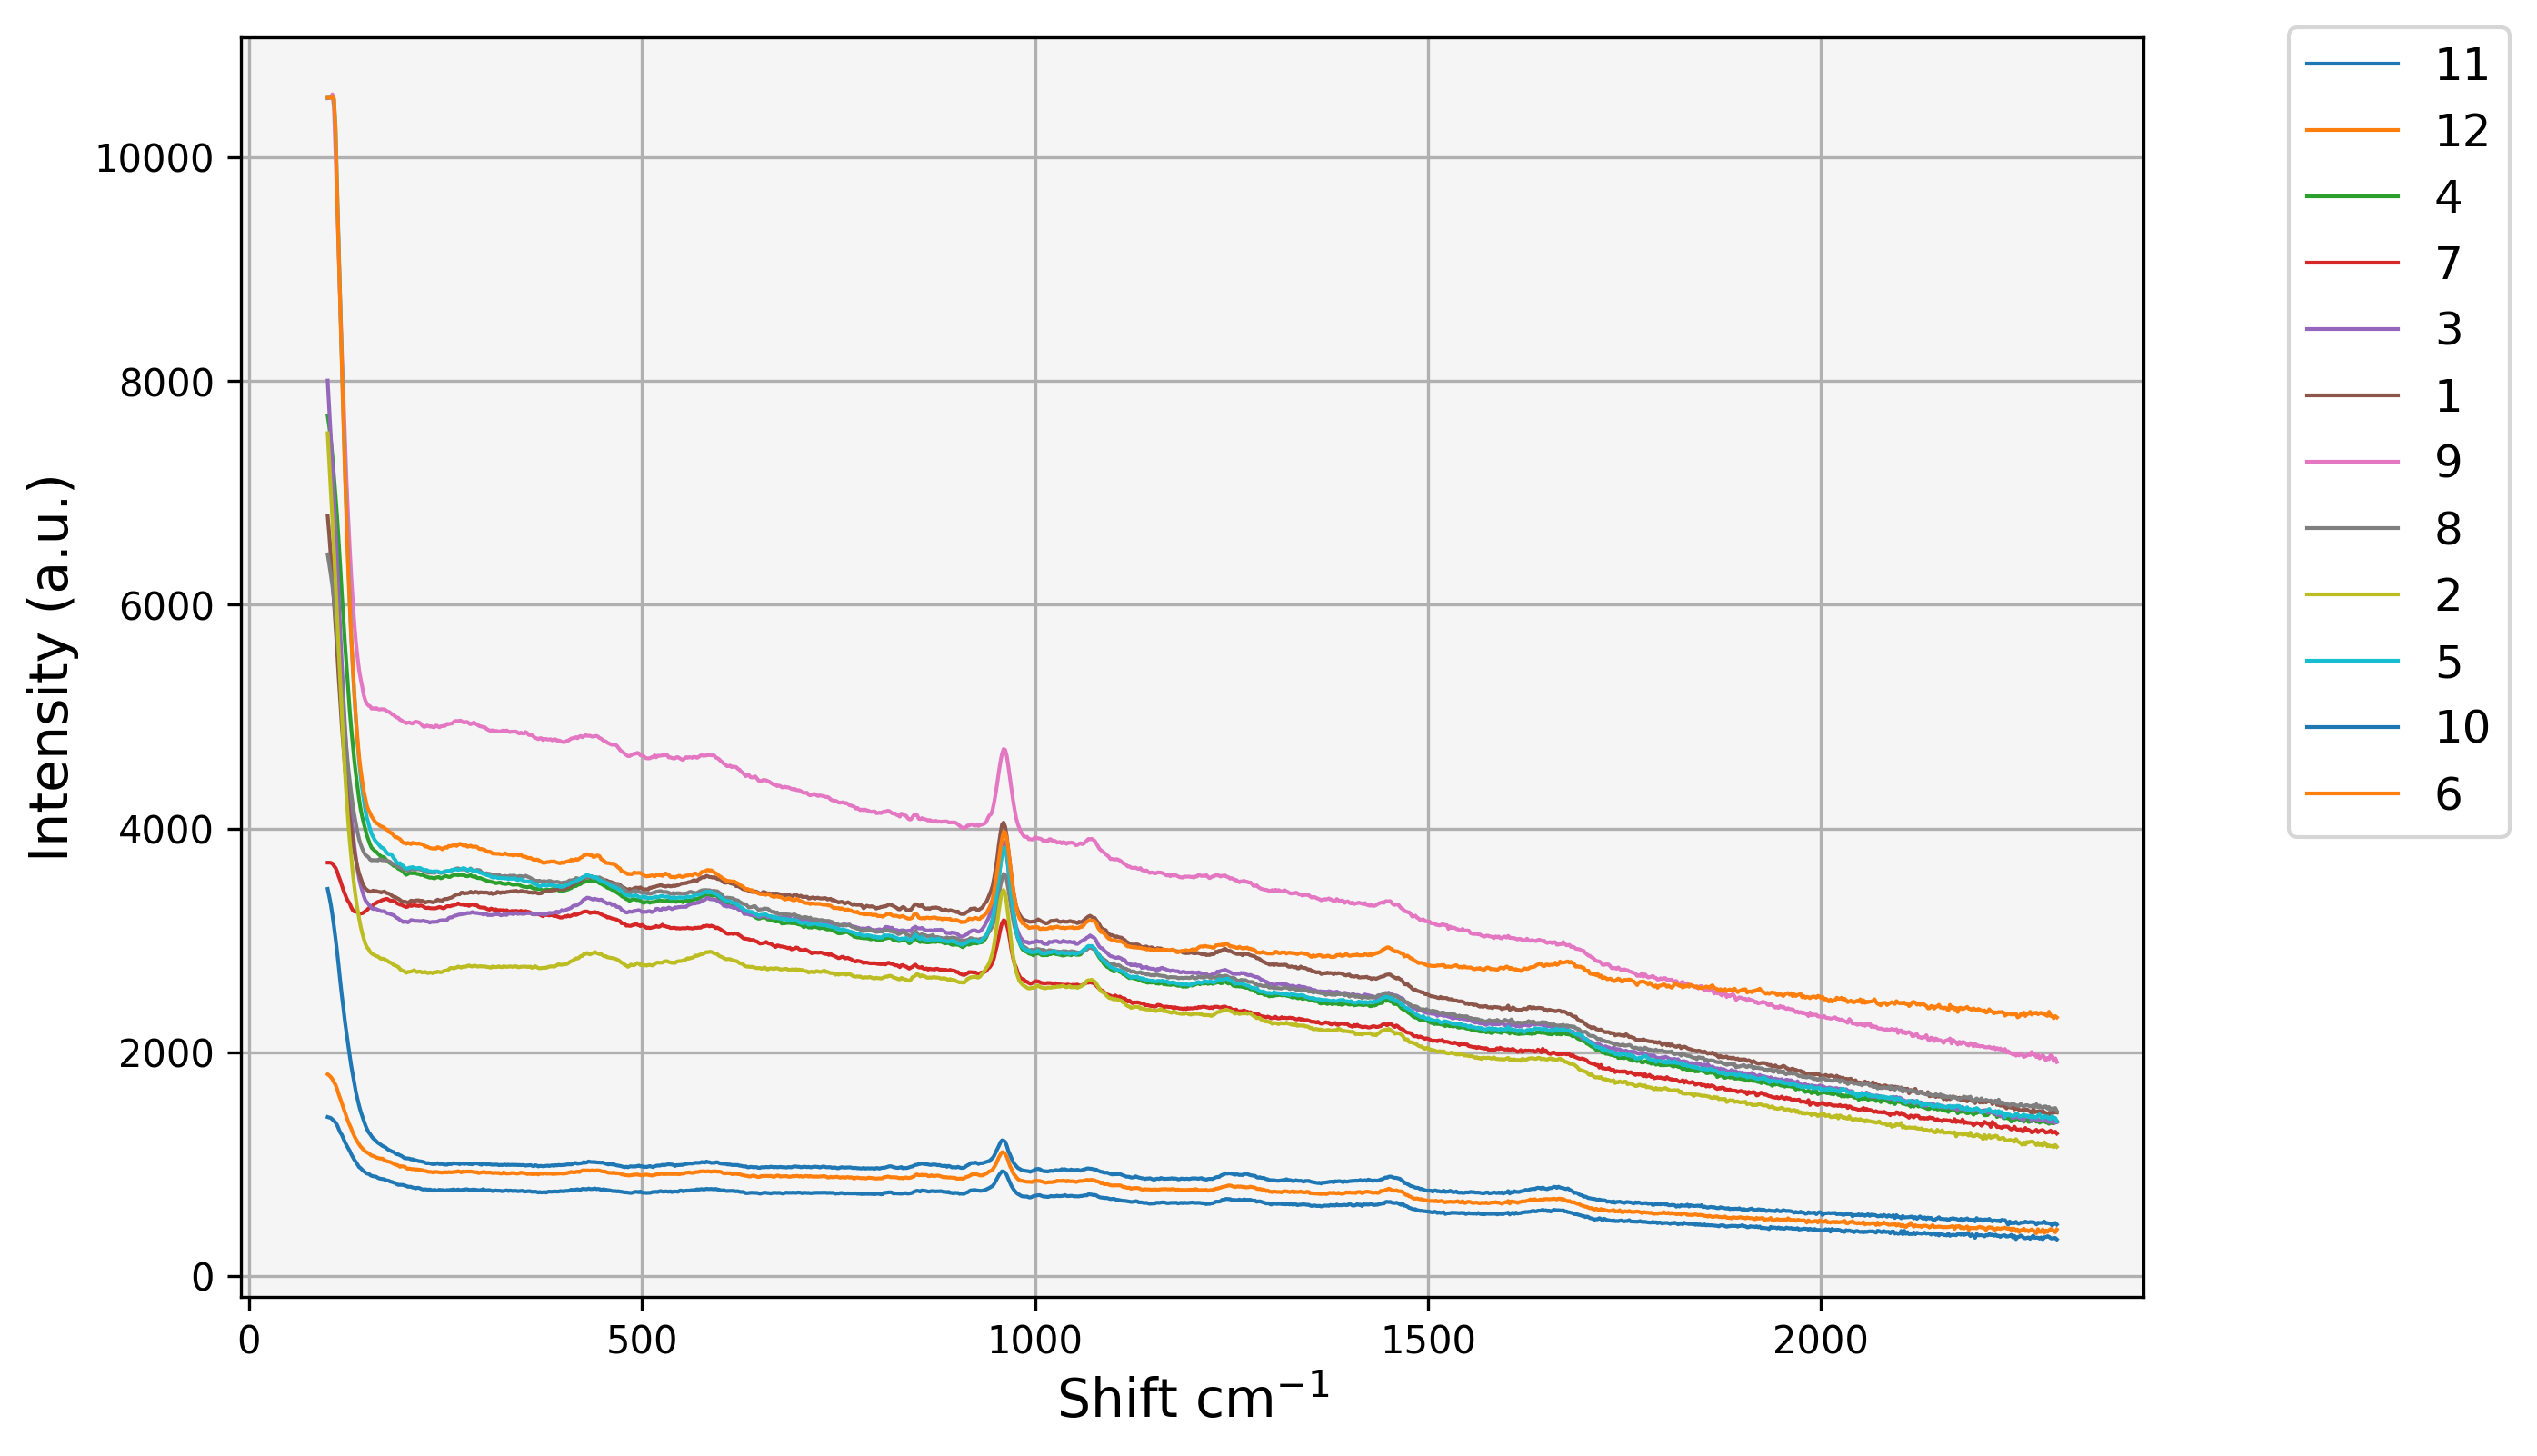

In [6]:
plot_dataframe(all_data,out_directory,nameit, 'RawData_All.png', show = True) # BG subtracted data plot

Backgroud substraction from the whole spectra:

In [7]:
def subtract_BG(frame, fitorder):
    """BG subtraction of the chosen fitorder
        extracts the BG based on the polynomial fit of the local minimas through the whole spectra
    """
    fit_index_start = round(frame.shape[1]*0.05)
    fit_index_end = round(frame.shape[1]*0.90)
    shifts = pd.DataFrame(frame.columns.values[fit_index_start:fit_index_end]).astype(float).T 
    counts = pd.DataFrame(frame.values[:, fit_index_start:fit_index_end]) #gets shifts without the first noisy peak and the last long "tail"
    minindex = pd.DataFrame()
    ymin = pd.DataFrame()
    xmin = pd.DataFrame()
    n = 20 # number of points to be checked before and after for min counts values
    for row in range(counts.shape[0]):
        minindex = pd.concat([minindex, pd.DataFrame(argrelextrema(counts.values[row,:], np.less_equal, order=n)[0]).T]).reset_index(drop=True) # gives a dataframe of indexes with minimal values
    minindex = minindex.fillna(counts.shape[1]-1) #to exclude NaN values fill in with the last index
    for row in range(counts.shape[0]):
        ymin = pd.concat([ymin, pd.DataFrame(counts.loc[row, minindex.values[row,:]].values).T]).reset_index(drop=True)
        xmin = pd.concat([xmin, pd.DataFrame(shifts.loc[:, minindex.values[row,:]].values)]).reset_index(drop=True) 
    ############# Fitting BG ############
    BGcounts = pd.DataFrame() #Background counts from linear fit
    p = pd.DataFrame() #parameters of linear fit y = p[0]*x + p[1]
    corrcounts = pd.DataFrame()
    counts = pd.DataFrame(frame.values[:, fit_index_start:fit_index_end]) # [:, 210:-290] update to remove shifts from the column names and perform subtraction afterwards
    for row in range(counts.shape[0]):
        p = pd.concat([p, pd.DataFrame(np.polyfit(xmin.values[row,:], ymin.values[row,:], fitorder)).T]).reset_index(drop=True)
    for row in range(counts.shape[0]):
        BGcounts = pd.concat([BGcounts, pd.DataFrame(np.polyval(p.values[row,:], shifts.values))]).reset_index(drop=True)
    corrcounts = counts.sub(BGcounts, fill_value=0) #subtracting BG 
    corrcounts.columns = shifts.T[0]   
    return corrcounts

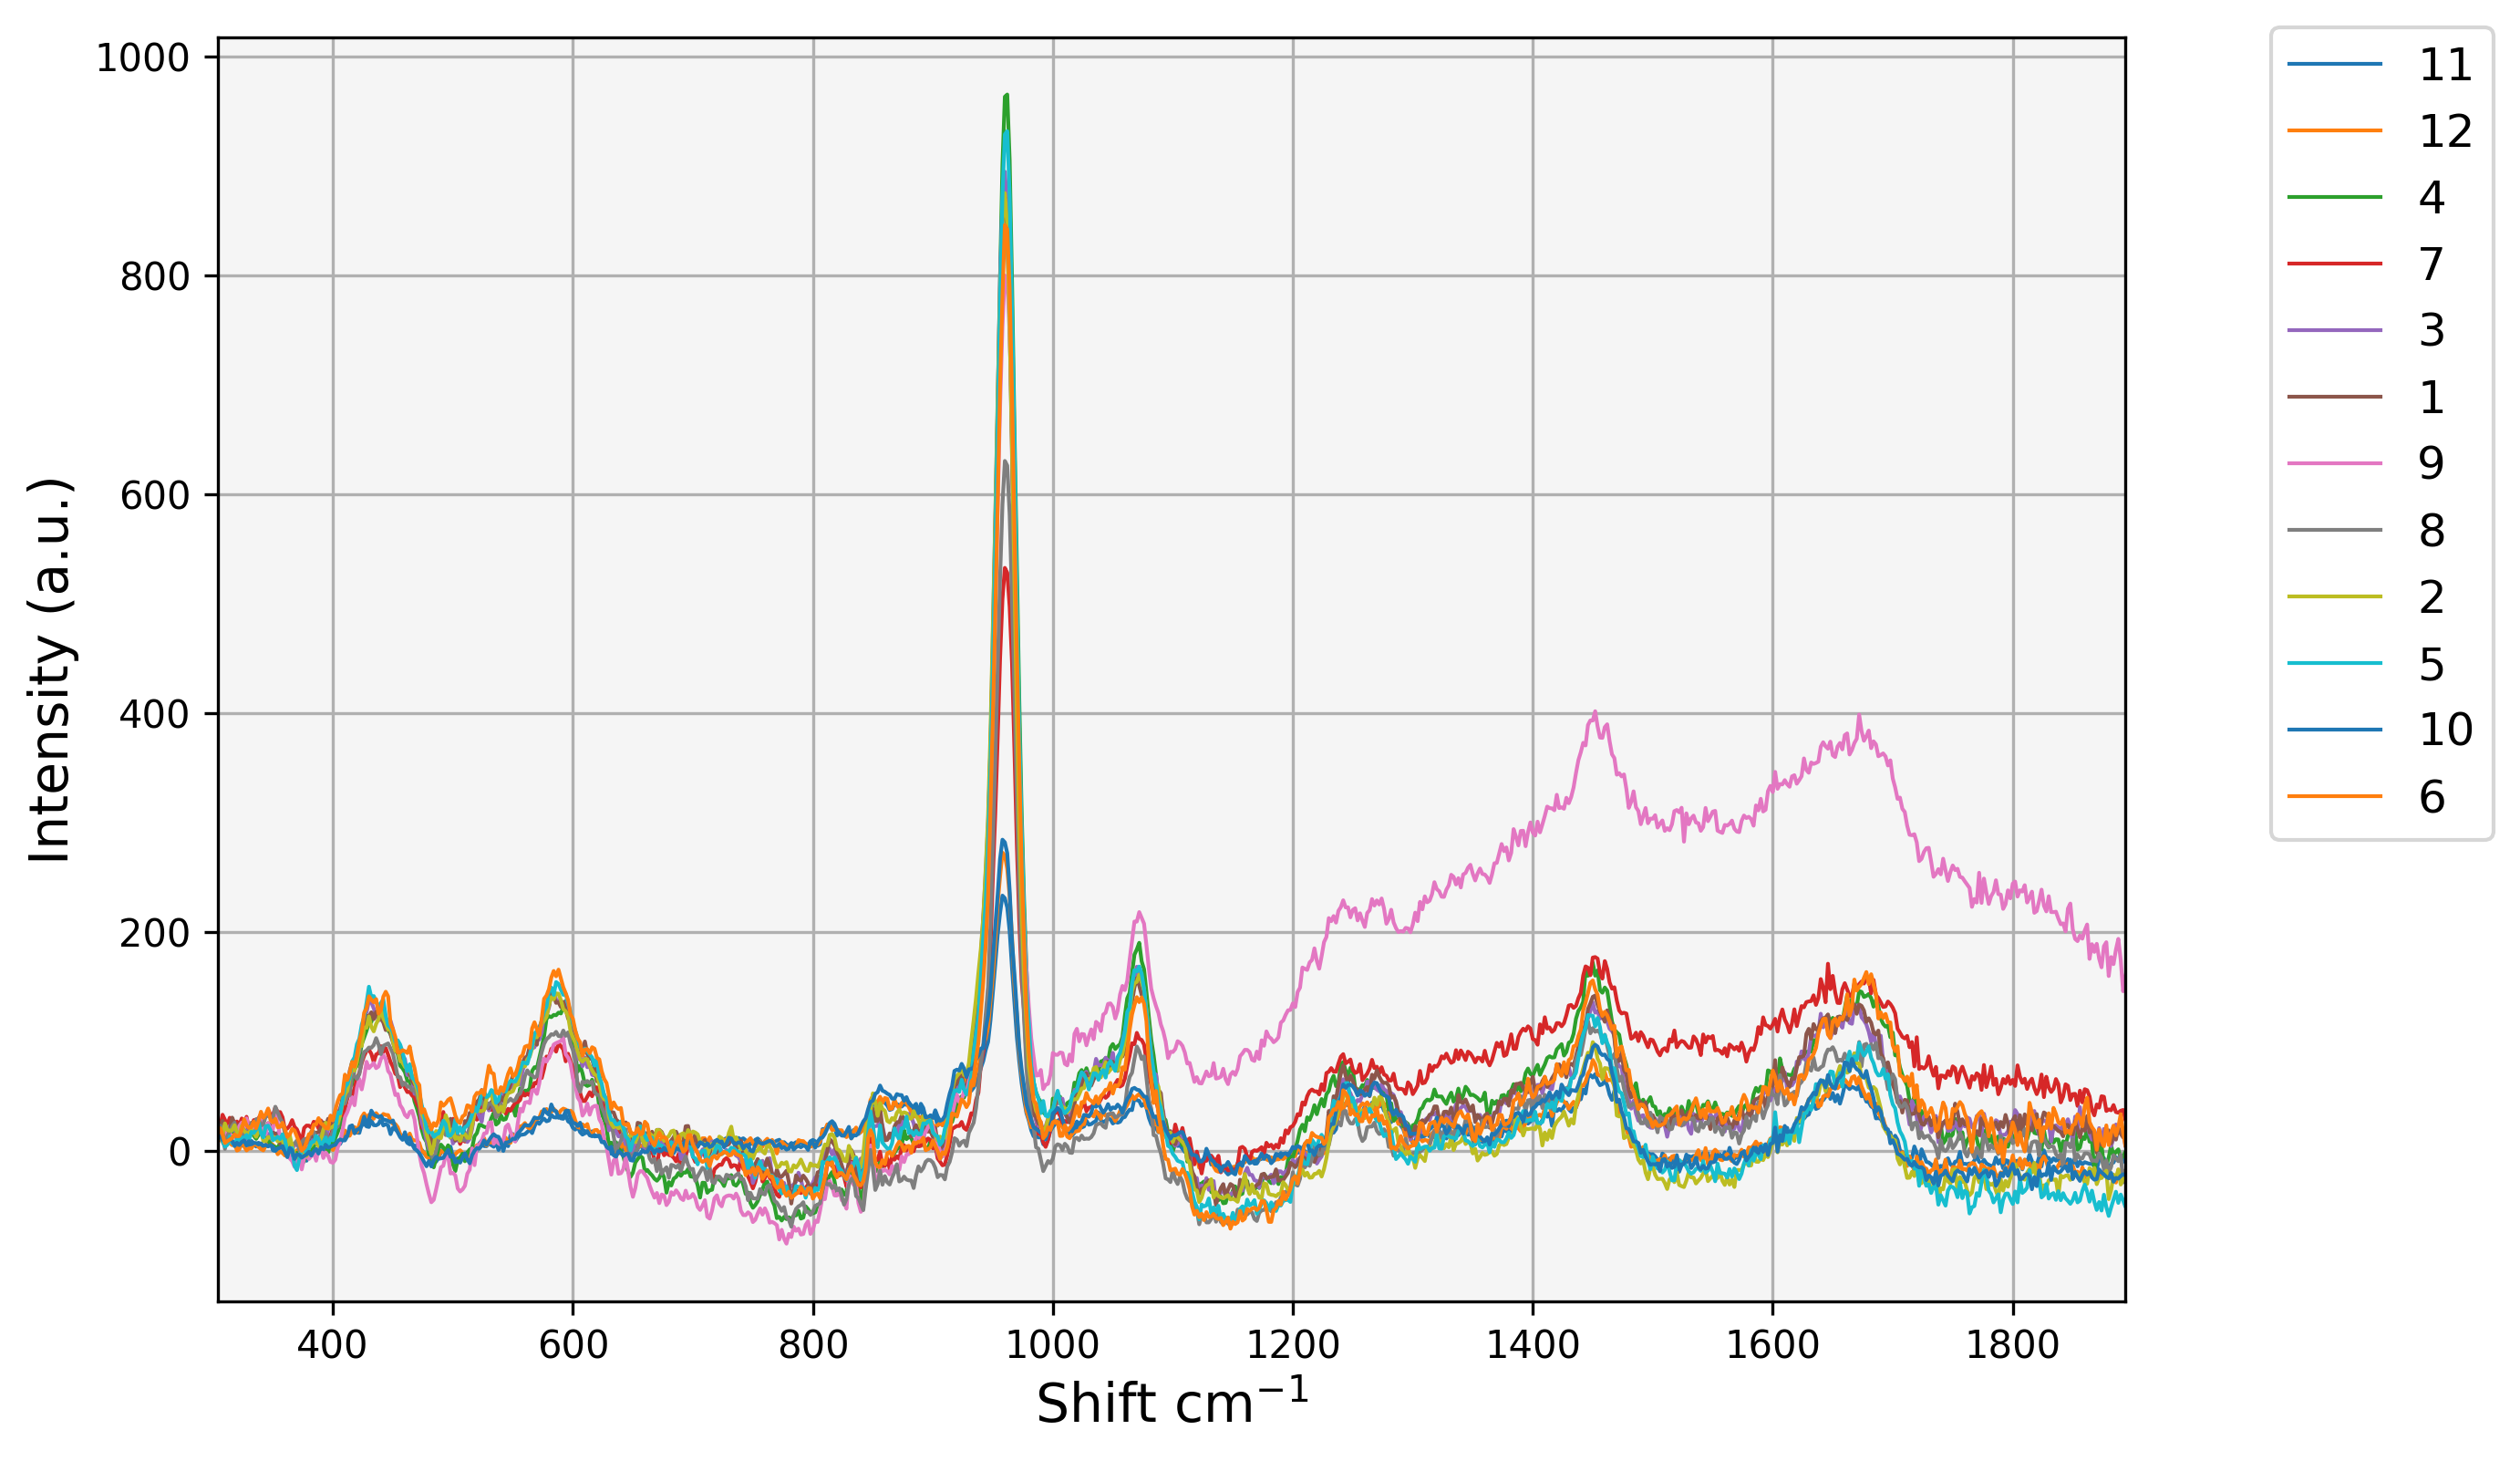

In [8]:
corrcounts = subtract_BG(all_data,fitorder=3)  # BG subtraction from ALL data
plot_dataframe(corrcounts,out_directory,nameit,'BGdata_All.png', cut = True, show = True) # BG subtracted data plot

Supplementary functions to fit Raman bands:

In [9]:
def subtract_peakBG(peakshifts, peakcounts): 
    """ Subtract BG from peak. Does linear fit through the left and right sides of the peak and subtracts it.
    """
    peak_shifts = pd.DataFrame(peakshifts).T
    peak_counts = pd.DataFrame(peakcounts) #get shifts without the first noisy peak in df format to use .iloc 
    x_left = pd.DataFrame(peak_shifts.values[0,0:5])
    x_right = pd.DataFrame(peak_shifts.values[0,-6:-1])
    #x_sides = pd.concat([x_left,x_right])
    x_sides = np.append(x_left, x_right)
    BGcounts = pd.DataFrame()
    p = pd.DataFrame()
    for row in range(peak_counts.shape[0]):
        y_left = pd.DataFrame(peak_counts.values[row,0:5])
        y_right = pd.DataFrame(peak_counts.values[row,-6:-1])
        y_sides = pd.concat([y_left, y_right])
        p = pd.concat([p,pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T]).reset_index(drop=True)
    for row in range(peak_counts.shape[0]):
        BGcounts = pd.concat([BGcounts,pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values))]).reset_index(drop=True)
    peak_corrcounts = peak_counts.sub(BGcounts, fill_value=0) #subtracting BG
    peak_corrcounts.columns = peak_shifts.T[0]
    return peak_corrcounts

# we use two function types for the Raman bands fit: single and double Lorentzian
def lorentzian(x, *p):        
        # p = [hwhm, peak center, intensity]
        numerator =  ( p[0]**2 )
        denominator = ( x - (p[1]) )**2 + p[0]**2
        y = p[2]*(numerator/denominator)
        return y 

def doublelorentzian(x, *p):        
        # p = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
        numerator0 =  ( p[0]**2 )
        denominator0 = ( x - (p[1]) )**2 + p[0]**2
        numerator1 =  ( p[3]**2 )
        denominator1 = ( x - (p[4]) )**2 + p[3]**2
        y = p[2]*(numerator0/denominator0)+p[5]*(numerator1/denominator1)
        return y 
    
# in accordance with the fitting function, we have two functions for calculating hte fitted Raman band properties
def peak_fit(peak_shifts, peak_corrcounts, plot = False): #if plot -> shows intermediate fittings
    """ Lorentzian fit 
    p0 = [hwhm #1, peak center #1, intensity #1]
    """
    x = peak_shifts
    peak_pos = []
    peak_FWHM = []
    peak_intensity = []
    peak_integral = pd.DataFrame()
    for row in range(peak_corrcounts.shape[0]):
        y = peak_corrcounts.values[row,:]
        p0 = [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)] 
        popt, pcov = curve_fit(lorentzian, x, y, p0)
        peak_pos = np.append(peak_pos, popt[1])
        peak_FWHM = np.append(peak_FWHM, popt[0])
        peak_intensity = np.append(peak_intensity, lorentzian(popt[1], *popt))  #maximum: 2.99846874275 18.3928199902
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: lorentzian(x, *popt), min(x), max(x))[0])
        if plot:
            plt.figure(figsize=(2.5, 2.5), dpi=300)
            x_curve = np.linspace(min(x), max(x), 50)
            plt.plot(x, y,'k.', fillstyle='none')
            plt.plot(x_curve, lorentzian(x_curve, *popt), color = 'grey')
            plt.plot(x_curve, lorentzian(x_curve, *popt), 'k.', fillstyle='none')
            plt.show()
    return peak_pos, peak_intensity, peak_FWHM, peak_integral

def doublepeak_fit(peak_shifts, peak_corrcounts, plot = False, amideI = False, amideIII = False, v2PO4 = False): #enable plot to see each peak fitting
    """ Double Lorentzian fit 
        p0 = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
    """
    x = peak_shifts
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    for row in range(peak_corrcounts.shape[0]):
        y = peak_corrcounts.values[row,:]
        if amideI: #left shoulder~1640 cm-1, right peak~1670 cm-1
            color = 'orange'
            bounds = ([0, 1625, 0, 0, 1655,0], [1e6, 1650, 0.75*(max(y)), 1e6, 1680, 1e6]) # bounds for pO, for beter fitting
            p0right, pcovright = curve_fit(lorentzian, x, y, [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)]) #use lorentzian fit for the right peak and use fitted parameters laater for double lorentzian fit
            p0 = np.append([0.2*p0right[0], 1645, 0.1*p0right[2]], p0right) #hwhm#1 = 0.2*hwhm#2, intensity#1 = 0.1*intensity#2
        if amideIII: #left peak ~1242 cm-1; right peak ~1272 cm-1
            xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
            xright = x[len(x)//2:]
            yleft = y[:len(y)//2]  
            yright = y[len(y)//2:] 
            bounds = ([0, 1237, 0, 0, 1267,0], [1e6, 1247, 1e6, 1e6, 1277, 1e6])
            p0 = [2.055*np.std(xleft)/2.0, 1242, max(yleft), 2.055*np.std(xright)/2.0, 1272, max(yright)] 
            color = 'tomato'
        if v2PO4: #main peak~431 cm-1, right shoulder~450 cm-1
            color = 'blue'
            xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
            xright = x[len(x)//2:]
            yleft = y[:len(y)//2]  
            yright = y[len(y)//2:] 
            bounds = ([0, 420, 0, 0, 445,0], [1e6, 440, 1e6, 1e6, 465, 1e5]) 
            p0 = [2.055*np.std(xleft)/2.0,  431, max(yleft), 2.055*np.std(xright)/2.0,  454, max(yright)]             
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if plot:
            plt.figure(figsize=(2.5, 2.5), dpi=400)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = color) 
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') 
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') 
            plt.show()
    return peak_pos_left, peak_intensity_left, peak_pos_right, peak_intensity_right, peak_integral 

Analysing Raman bands of interest:

### Amide I

In [10]:
def amideI_analysis(corrcounts, directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
         left shoulder~1645 cm-1, right peak~1665 cm-1
     OUTPUT: [0] peak position of amide I left shoulder, [1] peak intensity of amide I left shoulder, 
             [2] position of amide I right peak, [3] intensity of amide I right peak

    """
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 1550.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1780.)[0][0]
    amideI_counts = corrcounts.values[:,start_index:end_index] 
    amideI_shifts = shifts.values[0,start_index:end_index]
    amideI_corrcounts = subtract_peakBG(amideI_shifts, amideI_counts) #subtracting BG from amideI peak
    if peak_plot:
        plot_dataframe(amideI_corrcounts,directory,nameit, 'BGsubtracted_amideI.png') # and plot it
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = amideI_shifts
    for row in range(amideI_corrcounts.shape[0]):
        y = amideI_corrcounts.values[row,:]
        bounds = ([0, 1625, 0, 0, 1655,0], [1e6, 1650, 0.75*(max(y)), 1e6, 1690, 1e6]) # bounds for pO, for beter fitting
        p0right, pcovright = curve_fit(lorentzian, x, y, [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)]) #use lorentzian fit for the right peak and use fitted parameters laater for double lorentzian fit
        p0 = np.append([0.2*p0right[0], 1645, 0.1*p0right[2]], p0right) #hwhm#1 = 0.2*hwhm#2, intensity#1 = 0.1*intensity#2
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = 'orange') #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()
    amideI_param = {'amideI_pos_left': peak_pos_left, 
                 'amideI_intensity_left': peak_intensity_left, 
                 'amideI_pos_right': peak_pos_right, 
                 'amideI_intensity_right': peak_intensity_right, 
                 'amideI_integral': peak_integral}
    amideI_param = pd.DataFrame(data = amideI_param)
    return(amideI_param)

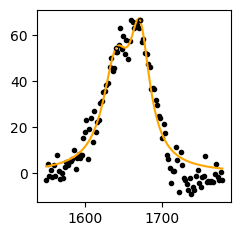

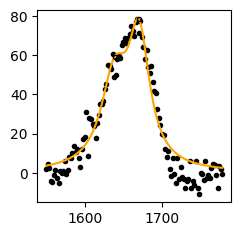

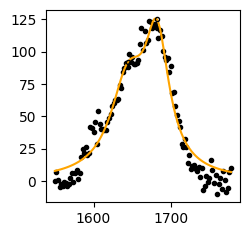

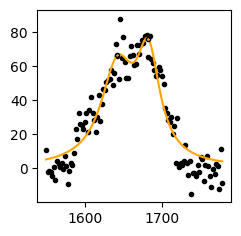

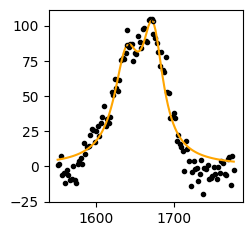

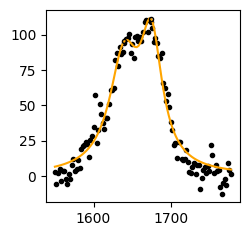

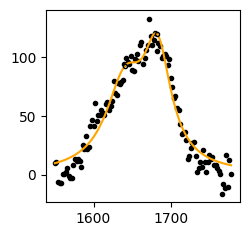

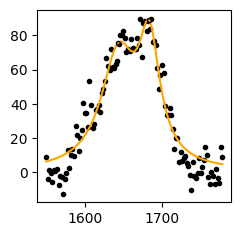

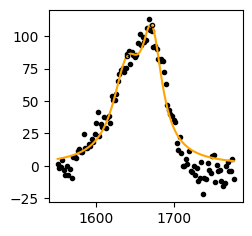

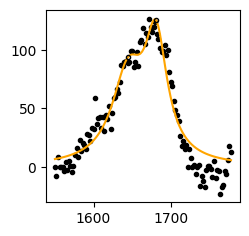

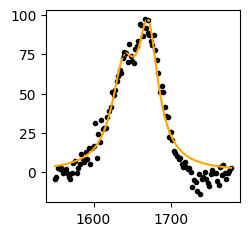

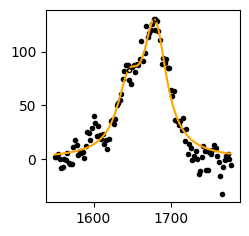

In [11]:
amideI_param = amideI_analysis(corrcounts, out_directory, fit_plot = True)

### Amide III

In [12]:
def amideIII_analysis(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
             left peak ~1242 cm-1; right peak ~1272 cm-1
         OUTPUT: [0] position of amide III left peak, [1] intensity of amide III left peak, 
                 [2] position of amide III right peak, [3] intensity of amide III right peak
                 
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 1186.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1310.)[0][0]

    amideIII_counts = corrcounts.values[:,start_index:end_index] 
    amideIII_shifts = shifts.values[0,start_index:end_index]
    amideIII_corrcounts = subtract_peakBG(amideIII_shifts, amideIII_counts) #subtracting BG from amideIII peak
    if peak_plot:
        plot_dataframe(amideIII_corrcounts,src_directory,nameit, 'BGsubtracted_amideIII.png') # and plot it
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = amideIII_shifts
    for row in range(amideIII_corrcounts.shape[0]):
        y = amideIII_corrcounts.values[row,:]
        xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
        xright = x[len(x)//2:]
        yleft = y[:len(y)//2]  
        yright = y[len(y)//2:] 
        bounds = ([0, 1237, 0, 0, 1267,0], [1e6, 1247, 1e6, 1e6, 1277, 1e6])
        p0 = [2.055*np.std(xleft)/2.0, 1242, max(yleft), 2.055*np.std(xright)/2.0, 1272, max(yright)]     
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = 'tomato') #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()
    amideIII_param = {'amideIII_pos_left': peak_pos_left, 
                 'amideIII_intensity_left': peak_intensity_left, 
                 'amideIII_pos_right': peak_pos_right, 
                 'amideIII_intensity_right': peak_intensity_right, 
                 'amideIII_integral': peak_integral}
    amideIII_param = pd.DataFrame(data = amideIII_param)    
    return(amideIII_param)

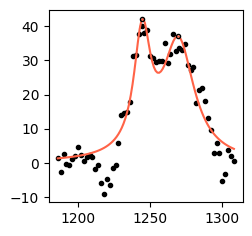

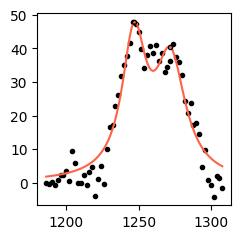

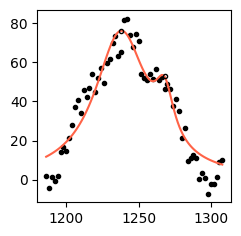

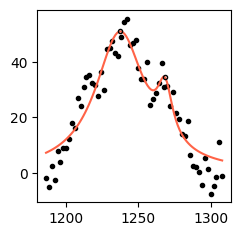

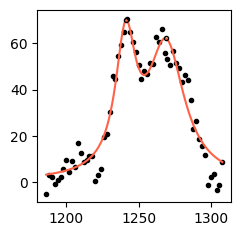

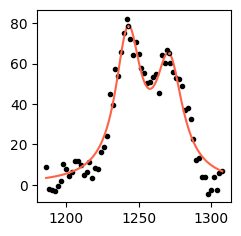

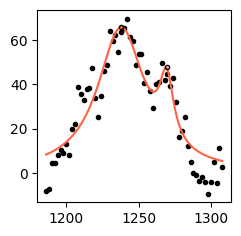

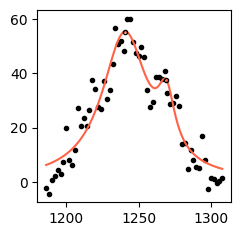

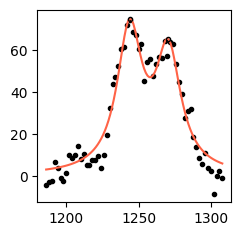

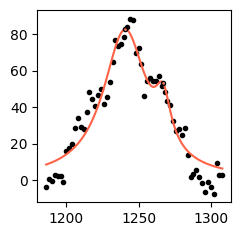

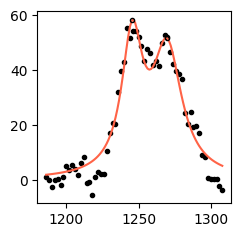

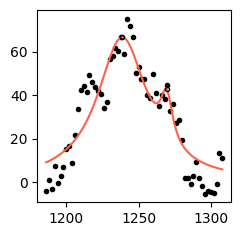

In [13]:
amideIII_param = amideIII_analysis(corrcounts, out_directory, fit_plot = True)

### $v_1PO_4$

In [14]:
def v1PO4_analysis(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
             peak ~960 cm-1           
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 920.)[0][0]
    end_index = np.where(shifts.values[0,:] == 1000.)[0][0]
    v1PO4_counts = corrcounts.values[:,start_index:end_index] 
    v1PO4_shifts = shifts.values[0,start_index:end_index]
    v1PO4_corrcounts = subtract_peakBG(v1PO4_shifts, v1PO4_counts) #subtracting BG from  v2PO4
    if peak_plot:
        plot_dataframe(v1PO4_corrcounts,src_directory,nameit, 'BGsubtracted_v1PO4.png') # and plot it
        
    peak_pos = []
    peak_FWHM = []
    peak_intensity = []
    peak_integral = pd.DataFrame()
    x = v1PO4_shifts
    for row in range(v1PO4_corrcounts.shape[0]):
        y = v1PO4_corrcounts.values[row,:]
        p0 = [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)] 
        popt, pcov = curve_fit(lorentzian, x, y, p0)
        peak_pos = np.append(peak_pos, popt[1])
        peak_FWHM = np.append(peak_FWHM, 2*popt[0])
        peak_intensity = np.append(peak_intensity, lorentzian(popt[1], *popt))
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: lorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y,'k.', fillstyle='none')
            plt.plot(x_curve, lorentzian(x_curve, *popt), color = 'grey')
            plt.plot(x_curve, lorentzian(x_curve, *popt), 'k.', fillstyle='none')
            plt.show()
    v1PO4_param = {'v1PO4_pos': peak_pos, 
                'v1PO4_intensity': peak_intensity, 
                'v1PO4_FWHM': peak_FWHM, 
                'v1PO4_integral': peak_integral}
    v1PO4_param = pd.DataFrame(data = v1PO4_param)
    return(v1PO4_param)  


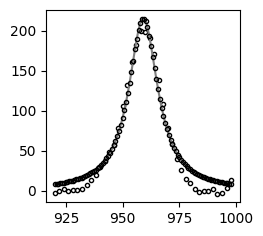

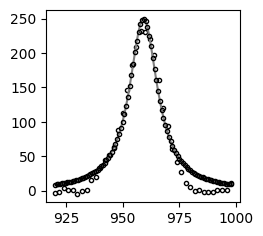

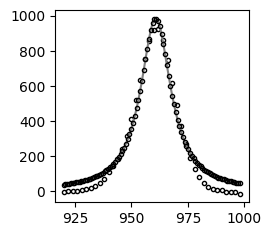

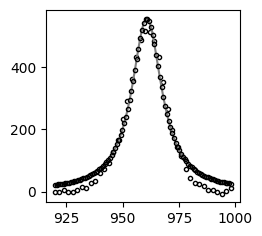

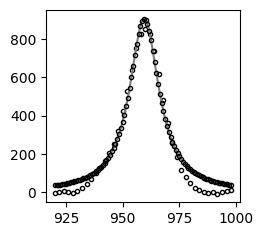

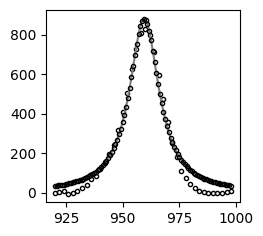

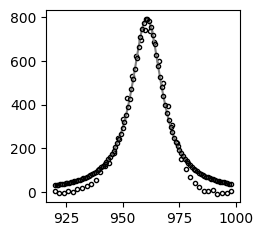

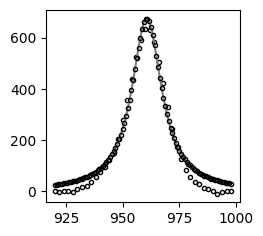

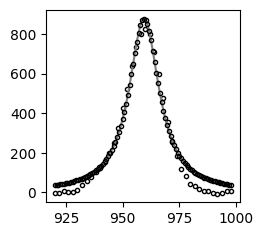

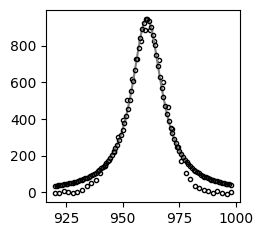

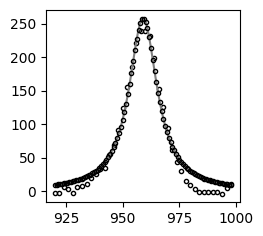

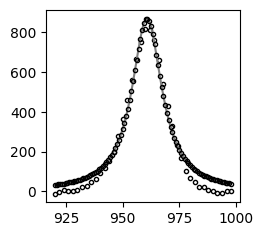

In [15]:
v1PO4_param = v1PO4_analysis(corrcounts, out_directory, fit_plot = True)

### $v_2PO_4$

In [16]:
def v2PO4_analysis(corrcounts, src_directory, peak_plot = True, fit_plot = False):
    """ peak_plot <- for plotting peak with subtracted BG
         polar_plot <- for the polar plot of intensity vs polarization angle
             left peak ~431 cm-1; right peak ~450 cm-1
         OUTPUT: [0] position of v2PO4 left peak, [1] intensity of v2PO4 left peak, 
                 [2] position of v2PO4 right peak, [3] intensity of v2PO4 right peak
                 
    """     
    shifts = pd.DataFrame(corrcounts.columns.values).T
    start_index = np.where(shifts.values[0,:] == 354.)[0][0]
    end_index = np.where(shifts.values[0,:] == 516.)[0][0]
    v2PO4_counts = corrcounts.values[:,start_index:end_index] 
    v2PO4_shifts = shifts.values[0,start_index:end_index]
    v2PO4_corrcounts = subtract_peakBG(v2PO4_shifts, v2PO4_counts) #subtracting BG from  v2PO4
    if peak_plot:
        plot_dataframe(v2PO4_corrcounts,src_directory,nameit, 'BGsubtracted_v2PO4.png') # and plot it
    
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
    x = v2PO4_shifts
    for row in range(v2PO4_corrcounts.shape[0]):
        y = v2PO4_corrcounts.values[row,:]
        xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
        xright = x[len(x)//2:]
        yleft = y[:len(y)//2]  
        yright = y[len(y)//2:] 
        bounds = ([0, 420, 0, 0, 445,0], [1e6, 440, 1e6, 1e6, 465, 1e5]) 
        p0 = [2.055*np.std(xleft)/2.0,  431, max(yleft), 2.055*np.std(xright)/2.0,  454, max(yright)]  
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
        if fit_plot:
            plt.figure(figsize=(2.5, 2.5), dpi=100)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = 'blue') #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()    
    v2PO4_param = {'v2PO4_pos_left': peak_pos_left, 
                   'v2PO4_intensity_left': peak_intensity_left, 
                   'v2PO4_pos_right': peak_pos_right, 
                   'v2PO4_intensity_right': peak_intensity_right, 
                   'v2PO4_integral': peak_integral}
    v2PO4_param = pd.DataFrame(data = v2PO4_param)
    return(v2PO4_param)

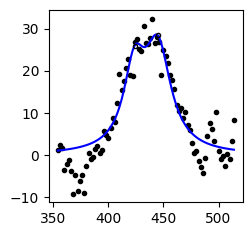

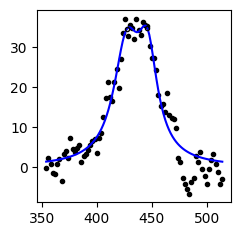

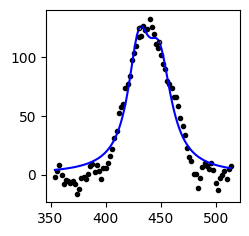

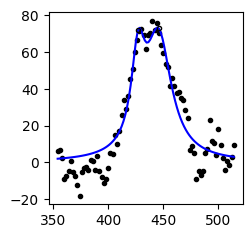

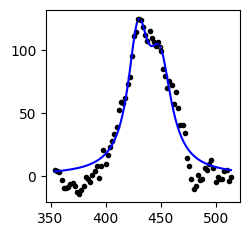

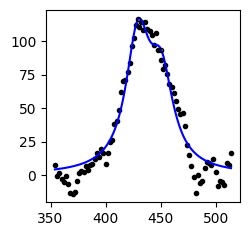

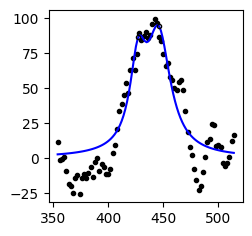

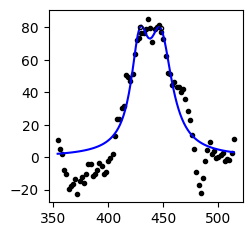

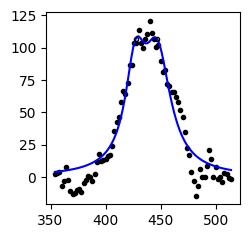

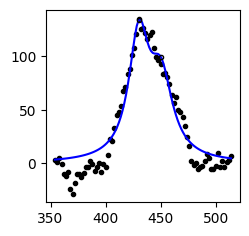

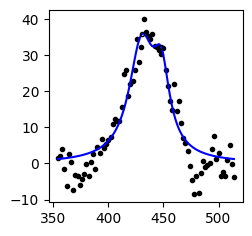

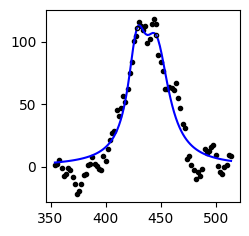

In [17]:
v2PO4_param = v2PO4_analysis(corrcounts, out_directory, fit_plot = True)

Creating matrix of Raman bands fit charachteristics:

In [18]:
output_data = pd.concat([amideI_param, amideIII_param], axis=1)
output_data = pd.concat([output_data, v1PO4_param], axis=1)
output_data = pd.concat([output_data, v2PO4_param], axis=1)
output_data.head()

,amideI_pos_left,amideI_intensity_left,amideI_pos_right,amideI_intensity_right,amideI_integral,amideIII_pos_left,amideIII_intensity_left,amideIII_pos_right,amideIII_intensity_right,amideIII_integral,v1PO4_pos,v1PO4_intensity,v1PO4_FWHM,v1PO4_integral,v2PO4_pos_left,v2PO4_intensity_left,v2PO4_pos_right,v2PO4_intensity_right,v2PO4_integral
0,1640.371567,54.371019,1671.183899,66.577035,4884.116097,1244.536551,42.237615,1269.525054,37.082052,1923.364715,959.137449,215.430609,15.707137,4642.835181,423.699749,25.935493,445.000000,28.358662,1582.026502
1,1638.492055,59.215929,1670.167629,78.410357,5702.311804,1246.872002,47.901853,1272.109078,40.403084,2328.546750,959.219223,250.204328,15.183051,5236.888283,427.024850,34.502212,446.017455,34.774675,1905.078460
2,1644.727140,92.164020,1682.097368,125.062118,10617.444740,1237.795664,76.113602,1267.999008,52.743995,4606.134774,960.766357,984.865954,16.242556,21837.139184,430.375155,124.748810,448.888413,113.041920,6454.256753
3,1642.148461,66.425494,1682.222455,76.220502,6962.928576,1237.271245,50.963370,1268.429756,34.473598,2935.458020,960.729592,555.634082,16.098880,12226.898851,427.156566,72.283894,445.712584,72.999309,3677.914823
4,1639.339511,86.127327,1673.080530,103.268538,7866.281153,1241.072111,69.987725,1269.097150,62.119753,3655.879970,959.552824,906.518638,15.861846,19701.284855,429.666623,124.963457,449.722551,103.034462,6067.408272


Calculating mineral to matrix ratio as the intergral area ratio of $\frac{v_2PO_4}{amide III}$ 

and adding directly to the output dataframe:

In [19]:
output_data['M2M_ratio_v2/a3'] = output_data['v2PO4_integral']/output_data['amideIII_integral']
output_data['M2M_ratio_v2/a3']

0     0.822531
1     0.818141
2     1.401231
3     1.252927
4     1.659630
5     1.582219
6     1.241992
7     1.320216
8     1.667594
9     1.437680
10    0.646350
11    1.491612
Name: M2M_ratio_v2/a3, dtype: float64


<span style='color:red; font-family:Arial'>What are the other Raman spectral charachteristics that we can calculate from the 
   available data?</span>
   
   

In [20]:
#TODO calculate at least one more meaningful spectral characteristic
#
#
#        

Next are the functions for qualitative and quantitative comparison between the two samples:
- Averaged spectra plot
- Boxplots of chosen Raman ratios


In [21]:
def plotSpectra_meanSD(df_mean,df_sd,color,plot_file, zonal = True, all_sample = False):
    plt.figure(figsize=(10, 6)) 
    plt.ioff()
    ax = plt.gca()
    for i in range(df_mean.shape[0]):
        if zonal:
            plot_label = 'Sample '+ df_mean['Sample'][i] + ' ' + df_mean['Zone'][i]
        if all_sample:
            plot_label = 'Sample '+ df_mean['Sample'][i]
        plt.plot(df_mean.iloc[i,2:], linewidth=2, color = color[i], label=plot_label) 
        plt.fill_between(df_mean.columns[2:].tolist(),
                         df_mean.iloc[i,2:].apply(pd.to_numeric, errors='coerce') + df_sd.iloc[i,2:].apply(pd.to_numeric, errors='coerce'),
                         df_mean.iloc[i,2:].apply(pd.to_numeric, errors='coerce') - df_sd.iloc[i,2:].apply(pd.to_numeric, errors='coerce'),
                         color = color[i], alpha=0.3)  # Adjust transparency as needed
    xlim = np.append(1.2*min(df_mean.columns[2:].tolist()), 0.9*max(df_mean.columns[2:].tolist())) # left and right boundaries for x axis
    ax.set_xlim(xlim) # set x axis boundaries
    ax.set_ylim(1.5*min(df_mean.iloc[0,2:]), 1.5*max(df_mean.iloc[0,2:])) # set x axis boundaries
    plt.xlabel('Raman Shifts [cm-1]')
    plt.ylabel('Intensity')
    plt.title('Averaged Spectrum with SD')
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    
    
def boxplot(df,y_column, x_column, colors, plot_title, x_label, y_label, plot_file):
    plt.figure(figsize=(8, 8))  # Adjust figure size as needed
    ax = plt.gca()
    sns.boxplot(data=df, x=x_column, y=y_column, hue=x_column, palette=colors.values())
    sns.swarmplot(data=df, x=x_column, y=y_column, color='black', size=10, alpha=0.8, dodge=True)
    plt.title(plot_title, fontsize=20)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(fontsize=14)  # Increase x-axis tick labels font size
    plt.yticks(fontsize=14)  # Increase y-axis tick labels font size
    ax.set_ylim(0.8*min(df[y_column]),1.2*max(df[y_column])) # set x axis boundaries
    plt.grid(True)
    #p-values
    samples = df[x_column].unique()
    for i in range(len(samples)):
        for j in range(i + 1, len(samples)):
            sample1 = df[df[x_column] == samples[i]][y_column]
            sample2 = df[df[x_column] == samples[j]][y_column]
            p_value = ttest_ind(sample1, sample2).pvalue
            asterisk_height = 1.1*max(max(sample1),max(sample2))+0.002*i*j # Adjust height of asterisks
            if p_value < 0.05:
                plt.text((i + j) / 2, 1.02*asterisk_height, 'p = '+str(np.round(p_value,3)), ha='center', va='center', fontsize=20)  # Adjust position and font size as needed
                plt.plot([i, j], [asterisk_height, asterisk_height], color='dimgrey', lw=2)  # Add brackets
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    #plt.show()

## Batch analysis part

In [23]:
sample_name = ['1', '2'] 
sample_zone = ['haversian', 'plexiform']
all_output_data = pd.DataFrame()
all_spectraBG_mean = pd.DataFrame()
all_spectraBG_SD = pd.DataFrame()

sample_corrcounts = pd.DataFrame()
sall_spectraBG_mean = pd.DataFrame()
sall_spectraBG_SD = pd.DataFrame()

for n in sample_name: 
    for z in sample_zone: 
        try:
            src_directory = data_directory +'/'+ n +'/'+ z
            all_data, nameit = combine_files(src_directory) #combining all .csv files from src_directory in one matrix
            corrcounts = subtract_BG(all_data,fitorder=2)  # BG subtraction from ALL data
            sample_corrcounts = pd.concat([sample_corrcounts, corrcounts], ignore_index=True) 
            plot_dataframe(all_data,src_directory,nameit,'RawData.png') # Raw spectrs plot
            plot_dataframe(corrcounts,src_directory,nameit,'BGdata.png',cut = True) # BG subtracted data plot

            #creating mean and SD dataframes for Zonal plots
            corrcounts_mean = pd.DataFrame(corrcounts.mean(axis=0)).T #calculating mean spectra from the measurement group
            corrcounts_mean.insert(0, "Sample", n, True)
            corrcounts_mean.insert(1, "Zone", z, True)
            corrcounts_sd = pd.DataFrame(corrcounts.std(axis=0)).T  #calculating SD of spectra from the measurement group
            corrcounts_sd.insert(0, "Sample", n, True)
            corrcounts_sd.insert(1, "Zone", z, True)        
            all_spectraBG_mean = pd.concat([all_spectraBG_mean, corrcounts_mean], ignore_index=True) # combining all mean spectra into one dataframe
            all_spectraBG_SD = pd.concat([all_spectraBG_SD, corrcounts_sd], ignore_index=True) # combining all SD of spectra into one dataframe

            #Calculating Ramam ratios
            amideI_param = amideI_analysis(corrcounts, src_directory)
            amideIII_param = amideIII_analysis(corrcounts, src_directory)
            v1PO4_param = v1PO4_analysis(corrcounts, src_directory)
            v2PO4_param = v2PO4_analysis(corrcounts, src_directory)
            output_data = pd.concat([amideI_param, amideIII_param], axis=1)
            output_data = pd.concat([output_data, v1PO4_param], axis=1)
            output_data = pd.concat([output_data, v2PO4_param], axis=1)
            output_data['M2M_ratio_v2/a3'] = output_data['v2PO4_integral']/output_data['amideIII_integral']

            #TODO calculate another meaningful spectral characteristic. Add it to output data and include in the boxplots

            output_data.insert(0, "Sample", n, True)
            output_data.insert(1, "Zone", z, True)
            all_output_data = pd.concat([all_output_data, output_data], ignore_index=True)
        except:
            pass 
    
    #Zonal analysis
    # Plotting averaged spectra with shaded standard deviation regions for two samples
    zonal_color = ['lightgrey','grey']
    plotSpectra_meanSD(df_mean = all_spectraBG_mean[all_spectraBG_mean['Sample']==n].reset_index(drop=True),
                       df_sd = all_spectraBG_SD,
                       color = zonal_color,
                       plot_file = os.path.join(out_directory, 'Sample-'+n+'_zonal_spectra_meanSD.png'),
                       zonal = True)

    # Boxplot of Raman ratio vs sample zone
    boxplot(df = all_output_data[all_output_data['Sample']==n],
                 y_column = 'M2M_ratio_v2/a3',
                 x_column = 'Zone',            
                 colors = {'1':zonal_color[0], 
                          '2':zonal_color[1]},          
                 plot_title = 'Relative mineralization',
                 x_label = 'Sample '+n,
                 y_label = 'Mineral/Matrix (v2PO4/amide III)',
                 plot_file = os.path.join(out_directory, n+'_MMRv2a3.png'))

    #creating mean and SD dataframes for all samples analysis
    sample_corrcounts_mean = pd.DataFrame(sample_corrcounts.mean(axis=0)).T #calculating mean spectra from the measurement group
    sample_corrcounts_mean.insert(0, "Sample", n, True)
    sample_corrcounts_mean.insert(1, "Zone", z, True)
    sample_corrcounts_sd = pd.DataFrame(sample_corrcounts.std(axis=0)).T  #calculating SD of spectra from the measurement group
    sample_corrcounts_sd.insert(0, "Sample", n, True)
    sample_corrcounts_sd.insert(1, "Zone", z, True)        
    sall_spectraBG_mean = pd.concat([sall_spectraBG_mean, sample_corrcounts_mean], ignore_index=True) # combining all mean spectra into one dataframe
    sall_spectraBG_SD = pd.concat([sall_spectraBG_SD, sample_corrcounts_sd], ignore_index=True) # combining all SD of spectra into one dataframe

    
    
# Sample comparison
# Plot averaged spectra with shaded standard deviation regions  
sample_colors = ['royalblue', 'tomato']
plotSpectra_meanSD(df_mean = sall_spectraBG_mean,
                   df_sd = sall_spectraBG_SD,
                   color = sample_colors,
                   plot_file = os.path.join(out_directory, 'All_samples_spectra_meanSD.png'),
                   all_sample = True)


# Boxplot of Raman ratio vs sample zone
boxplot(df = all_output_data,
             y_column = 'M2M_ratio_v2/a3',
             x_column = 'Sample',            
             colors = {'1':sample_colors[0], 
                      '2':sample_colors[1]},          
             plot_title = 'Relative mineralization',
             x_label = 'All samples',
             y_label = 'Mineral/Matrix (v2PO4/amide III)',
             plot_file = os.path.join(out_directory, 'Allsamples_MMRv2a3.png'))


#saving dataframes
all_output_data.to_csv(os.path.join(out_directory, 'Output_data.csv'))
